In [1]:
# from core import readfiles
import numpy as np
import os
import multiprocessing as mul
import matplotlib.pyplot as plt
from numba import jit, njit, prange, set_num_threads, vectorize, guvectorize, cuda
from tqdm import tqdm
from core.signal_bag import *
from core.stacking_analysis import *
from core.req_vectors import *
import pickle
import scipy.stats as st
import scipy.interpolate as interp
# import torch
# from core import weights

read icdata
read uptdata
read eadata
read mspdata


In [2]:
from matplotlib.ticker import MaxNLocator, NullLocator,AutoMinorLocator
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter

In [3]:
from scipy.optimize import curve_fit

In [3]:
print(icra.shape)
print(hess_ra.shape)
print(icdec.shape)
print(icetrackdec.shape)
print(len(icetrackdeng))

(1134450,)
(95,)
(1134450,)
(275,)
275


In [5]:
gammaraysrc1ra=np.concatenate([lhsaao1ra, hess_ra], 0)
gammaraysrc1dec=np.concatenate([lhsaao1dec, hess_dec], 0)
gammaraysrc2ra=np.concatenate([lhsaao2ra, hess_ra], 0)
gammaraysrc2dec=np.concatenate([lhsaao2dec, hess_dec], 0)
# icra=np.hstack([icra,icetrackra])
# icdec=np.hstack([icdec,icetrackdec])
# icang=np.hstack([icang,icetrackdeng])
print(icdec.shape,icang.shape,icra.shape)

(1134450,) (1134450,) (1134450,)


In [8]:
num_threads = int(mul.cpu_count()*0.9)
set_num_threads(num_threads)

In [4]:
#Compute the signal PDF for all neutrinos as per eqns 6, 7 and weights as per eqn 8 of 2205.15963

@njit(nogil=True)
def S_ijk(i,nu): 

    '''
    Calculates S_ij as in EQN 7 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample
        
    
    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''
    ang2 = hvovec(gammaraysrc1ra[i], gammaraysrc1dec[i], icra[nu], icdec[nu], rad=True) ** 2      #rad**2
    sg = np.deg2rad(icang[nu]) ** 2                                     #rad**2
    return np.divide(np.exp(-1 * np.divide(ang2, 2*sg)), (2 * np.pi * sg))      #1/rad**2

# @jit(nopython=True)
@vectorize(['float64(int64)'], nopython=True,target='parallel')
def Bi_single_compute(i):

    '''
    Calculates B_i as in EQN 9 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino from IceCube sample
    cone : float
        Cone angle in degrees.
    

    Returns
    -------
    float
        Returns the background PDF for the {nu}th neutrino
    '''

    # count = np.sum(np.abs(np.subtract(icdec, icdec[nu])) <= cone)
    # count=0
    # for n in prange(len(icdec)):
    #     if abs(icdec[n] - lhsaao1dec[i]) <= 5:
    #         count+=1
    binwidth = (np.sin(np.deg2rad(gammaraysrc1ra[i] - 5)) - np.sin(np.deg2rad(gammaraysrc1dec[i] + 5)))*2*np.pi
    return 1/binwidth           #No units or sr**-1

In [12]:
@jit(nopython=True)
def Pr(x, Ns, S, B):
    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))



@njit(nogil=True)
# d@njit(nogil=True)
def TS_st_vec(x, S, B, Ns):
    nsN = x/Ns
    pr = np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))
    return np.sum(np.asfarray(2*np.log10(pr/B)))

lnu = 1134725
Ns = lnu#np.count_nonzero(nuind+1)

In [18]:
#lenic=1134450
Ts_max=[]
C=[]
for i in range(len(lhsaao1dec)):
    Ts_vec=[]
    S_i=[]

    count=0
    for n in prange(len(icdec)):
        if abs(icdec[n] - lhsaao1dec[i]) <= 5:
            count+=1
            S_i.append(S_ijk(i,n))
    S_i=np.array(S_i)
    #solid_angle=(np.sin(np.deg2rad(lhsaao1dec[i] + 5)) - np.sin(np.deg2rad(lhsaao1dec[i] - 5)))*2*np.pi
    #B_i=count/(solid_angle * lenic)
    count_arr=[i for i in range(count)]
    B_i=Bi_single_compute(i)
    #print(B_i)
    # P_i=Pr(count,Ns,S_i,B_i)
#     ns=np.zeros(count)
   
    for c in prange(len(count_arr)):

        # P_i=[]
        # for j in range(len(S_i)):
        #     Pi=Pr(count_arr[c],Ns,S_i[j],B_i)
        #     Pi=2*np.log10(Pi/B_i)
        #     P_i.append(Pi)
        #Ts=np.sum(P_i)
        # print(count_arr[c],S_i[1],B_i,Ns)
        # ns[c]= c
        # P_i=(c/count)*S_i+(1-c/count)*B_i
        # Lns[c]=np.prod(P_i)
        # Ts_vec=TS_st_vec()
        Ts=TS_st_vec(count_arr[c],S_i,B_i,Ns)
        Ts_vec.append(Ts)
    Ts_vec= [a_ for a_ in Ts_vec if a_ == a_]

    C.append(count_arr[np.argmax(Ts_vec)])
    Ts_max.append(Ts_vec[np.argmax(Ts_vec)])
if os.path.exists('Ts_max.txt'):
    os.remove('Ts_max.txt')
    
with open ('Ts_max.txt','a+') as f:
     #Ts.append
    for i in range(len(Ts_max)):
        f.write(str(C[i]))
        f.write('   ')
        f.write(str(Ts_max[i]))
        f.write('\n')
    f.close()

In [27]:
mylist=[ 1., 2.,  3., -3.0, np.nan,  4.,  5.,  6., np.nan,  7.,  8.,  9., np.nan]
mylist= [a_ for a_ in mylist if a_ == a_]
print(mylist)

[1.0, 2.0, 3.0, -3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]


In [19]:
Ts_max=np.loadtxt('Ts_max.txt',usecols=(1))
print(Ts_max)

[9.28633776e+00 1.61631453e+02 4.27297327e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.95855377e+01 4.99703679e+00
 7.46527832e+00 5.80644081e+00 1.00307900e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [16]:
Ts_max= [a_ for a_ in Ts_max if a_ == a_]
print(len(Ts_max))

150


In [20]:
Ts_max=np.array(Ts_max)
# Ts_max=Ts_max.pop('nan')
Ts_max = Ts_max[~np.isnan(Ts_max)]
print(len(Ts_max))

75


In [21]:
Ts_max=np.sqrt(Ts_max)
print(Ts_max)

[ 3.0473493  12.71343594  6.53679835  0.          0.          0.
  4.42555507  2.23540529  2.73226615  2.40965575  3.16714225  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.16685537  0.          2.29703223  3.44894276
  4.31403083  4.50146642  3.92592787]


In [22]:
def gauss1(x, H,A, x0, sigma):
    return  H +A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
def gauss(x, A, x0, sigma):
    return  A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

[ 0.          1.27320509  2.54641018  3.81961527  5.09282035  6.36602544
  7.63923053  8.91243562 10.18564071 11.4588458  12.73205089] 
 <BarContainer object of 10 artists>
[ 0.63660254  1.90980763  3.18301272  4.45621781  5.7294229   7.00262799
  8.27583308  9.54903816 10.82224325 12.09544834] 
 [62.  3.  4.  4.  0.  1.  0.  0.  0.  1.]


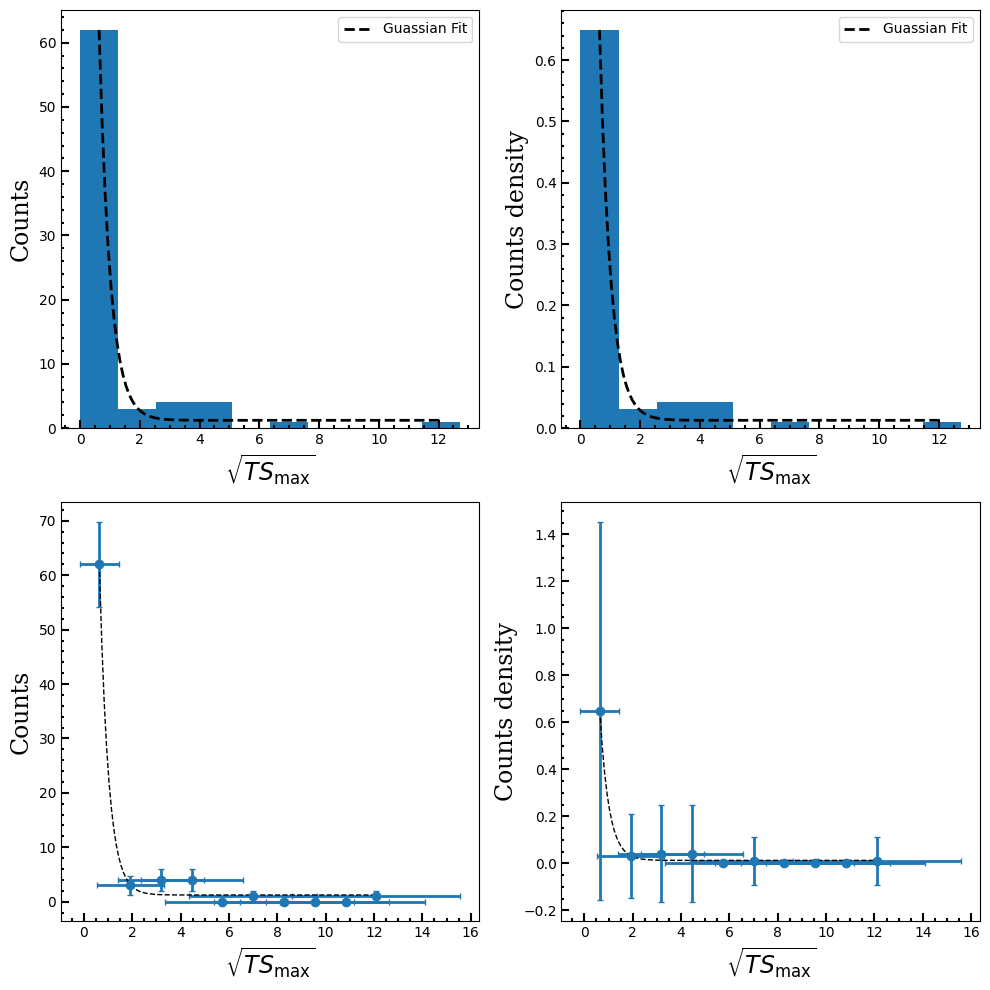

In [31]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator, NullLocator
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 17,
        }
n_bins = 10
fig, axs = plt.subplots(2, 2, tight_layout=True,figsize=(10, 10))
axs[0][0].set_ylabel('Counts',axesfont)
axs[0][0].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)
axs[1][0].set_ylabel('Counts',axesfont)
axs[1][0].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs[0][0].hist(Ts_max, bins=n_bins,linewidth=3)
print(bins,'\n',patches)
xdata=(bins[:-1]+bins[1:])*0.5
ydata=N
xplot=np.arange(min(xdata)-0.00001,max(xdata),0.1)

print(xdata,'\n',ydata)
# We'll color code by height, but you could use any scalar
parameters, covariance = curve_fit(gauss1, xdata, ydata,maxfev=5000000)
# parameters1,covariance1=curve_fit(gauss,xdata, ydata,maxfev=500000)
# fit_A = parameters[0]
# fit_B = parameters[1]

fit_y = gauss1(xplot, *parameters)

# axs[0].plot(xplot, fit_y, '--', label='fit',c='green')
axs[0][0].plot(xplot, fit_y, '--', label='Guassian Fit',c='k',linewidth=2)
axs[1][0].errorbar(xdata, ydata, xerr=np.sqrt(xdata), yerr=np.sqrt(ydata), fmt='o', elinewidth=2,capsize=2)
axs[1][0].plot(xplot, fit_y, '--', label='Guassian Fit',c='k',linewidth=1)
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
# for thisfrac, thispatch in zip(fracs, patches):
#     color = plt.cm.viridis(norm(thisfrac))
#     thispatch.set_facecolor(color)

# We can also normalize our inputs by the total number of counts
N1, bins1, patches1 = axs[0][1].hist(Ts_max, bins=n_bins, density=True)
axs[0][1].set_ylabel('Counts density',axesfont)
axs[0][1].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)
axs[1][1].set_ylabel('Counts density',axesfont)
axs[1][1].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)
xdata1=(bins[:-1]+bins[1:])*0.5
ydata1=N1
xplot1=np.arange(min(xdata1)-0.00001,max(xdata1),0.1)
parameters1,covariance1=curve_fit(gauss1,xdata1, ydata1,maxfev=500000)
fit_y1=gauss1(xplot1, *parameters1)

axs[0][1].plot(xplot1, fit_y1, '--', label='Guassian Fit',c='k',linewidth=2)
axs[1][1].errorbar(xdata1, ydata1, xerr=np.sqrt(xdata1), yerr=np.sqrt(ydata1), fmt='o', elinewidth=2,capsize=2)
axs[1][1].plot(xplot1, fit_y1, '--', label='Guassian Fit',c='k',linewidth=1)
# Now we format the y-axis to display percentage
#axs[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))
axs[0][0].tick_params(which='major', width=1.5, length=6,direction='in')
axs[0][0].tick_params(which='minor', width=1.5, length=3,direction='in')
axs[0][1].tick_params(which='major', width=1.5, length=6,direction='in')
axs[0][1].tick_params(which='minor', width=1.5, length=3,direction='in')
axs[1][0].tick_params(which='major', width=1.5, length=6,direction='in')
axs[1][0].tick_params(which='minor', width=1.5, length=3,direction='in')
axs[1][1].tick_params(which='major', width=1.5, length=6,direction='in')
axs[1][1].tick_params(which='minor', width=1.5, length=3,direction='in')
#axs[1].xaxis.set_minor_locator(MultipleLocator(5))
axs[0][0].legend()
# axs[1].xaxis.set_minor_locator(MultipleLocator(5))
axs[0][1].legend()
axs[0][0].xaxis.set_minor_locator(AutoMinorLocator())
axs[0][0].yaxis.set_minor_locator(AutoMinorLocator())
axs[0][0].tick_params(which='minor', length=2, color='k')
# For the minor ticks, use no labels; default NullFormatter.
axs[0][1].xaxis.set_minor_locator(AutoMinorLocator())
axs[0][1].yaxis.set_minor_locator(AutoMinorLocator())
axs[0][1].tick_params(which='minor', length=2, color='k')
axs[1][0].xaxis.set_minor_locator(AutoMinorLocator())
axs[1][0].yaxis.set_minor_locator(AutoMinorLocator())
axs[1][0].tick_params(which='minor', length=2, color='k')
axs[1][1].xaxis.set_minor_locator(AutoMinorLocator())
axs[1][1].yaxis.set_minor_locator(AutoMinorLocator())
axs[1][1].tick_params(which='minor', length=2, color='k')
# axs[1][0].set_xscale('log')
# axs[1][1].set_xscale('log')
# axs[1][0].set_yscale('log')
# axs[1][1].set_yscale('log')
# axs[0][0].set_yscale('log')
# axs[0][1].set_yscale('log')
# axs[0][0].set_xscale('log')
# axs[0][1].set_xscale('log')
fig.savefig('Ts_max_distr.pdf')

[ 0.6356718   1.90701539  3.17835898  4.44970258  5.72104617  6.99238977
  8.26373336  9.53507695 10.80642055 12.07776414] 
 [62.  3.  4.  4.  0.  1.  0.  0.  0.  1.]


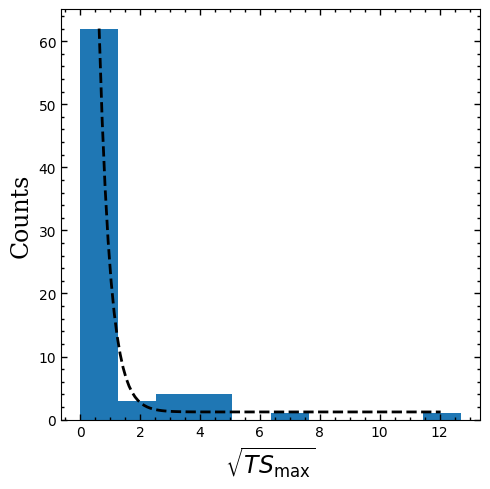

In [23]:
font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 17,
        }
n_bins = 10
fig, axs = plt.subplots(1, 1, tight_layout=True,figsize=(5, 5))
axs.set_ylabel('Counts',axesfont)
axs.set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)
# axs[1][0].set_ylabel('Counts',axesfont)
# axs[1][0].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs.hist(Ts_max, bins=n_bins,linewidth=3)
#print(bins,'\n',patches)
xdata=(bins[:-1]+bins[1:])*0.5
ydata=N
xplot=np.arange(min(xdata)-0.00001,max(xdata),0.1)

print(xdata,'\n',ydata)
# We'll color code by height, but you could use any scalar
parameters, covariance = curve_fit(gauss1, xdata, ydata,maxfev=5000000)
# parameters1,covariance1=curve_fit(gauss,xdata, ydata,maxfev=500000)
# fit_A = parameters[0]
# fit_B = parameters[1]

fit_y = gauss1(xplot, *parameters)

# axs[0].plot(xplot, fit_y, '--', label='fit',c='green')
axs.plot(xplot, fit_y, '--', label='Guassian Fit',c='k',linewidth=2)
# axs[1][0].errorbar(xdata, ydata, xerr=np.sqrt(xdata), yerr=np.sqrt(ydata), fmt='o', elinewidth=2,capsize=2)
# axs[1][0].plot(xplot, fit_y, '--', label='Guassian Fit',c='k',linewidth=1)
# fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
# norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
# for thisfrac, thispatch in zip(fracs, patches):
#     color = plt.cm.viridis(norm(thisfrac))
#     thispatch.set_facecolor(color)

# We can also normalize our inputs by the total number of counts
# N1, bins1, patches1 = axs[0][1].hist(Ts_max, bins=n_bins, density=True)
# axs[0][1].set_ylabel('Counts density',axesfont)
# axs[0][1].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)
# axs[1][1].set_ylabel('Counts density',axesfont)
# axs[1][1].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)
# xdata1=(bins[:-1]+bins[1:])*0.5
# ydata1=N1
# xplot1=np.arange(min(xdata1)-0.00001,max(xdata1),0.1)
# parameters1,covariance1=curve_fit(gauss1,xdata1, ydata1,maxfev=500000)
# fit_y1=gauss1(xplot1, *parameters1)

# axs[0][1].plot(xplot1, fit_y1, '--', label='Guassian Fit',c='k',linewidth=2)
# axs[1][1].errorbar(xdata1, ydata1, xerr=np.sqrt(xdata1), yerr=np.sqrt(ydata1), fmt='o', elinewidth=2,capsize=2)
# axs[1][1].plot(xplot1, fit_y1, '--', label='Guassian Fit',c='k',linewidth=1)
# Now we format the y-axis to display percentage
#axs[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))
axs.tick_params(which='major', width=1.5, length=6,direction='in')
axs.tick_params(which='minor', width=1.5, length=3,direction='in')
# axs[0][1].tick_params(which='major', width=1.5, length=6,direction='in')
# axs[0][1].tick_params(which='minor', width=1.5, length=3,direction='in')
# axs[1][0].tick_params(which='major', width=1.5, length=6,direction='in')
# axs[1][0].tick_params(which='minor', width=1.5, length=3,direction='in')
# axs[1][1].tick_params(which='major', width=1.5, length=6,direction='in')
# axs[1][1].tick_params(which='minor', width=1.5, length=3,direction='in')
# #axs[1].xaxis.set_minor_locator(MultipleLocator(5))
# axs[0][0].legend()
# # axs[1].xaxis.set_minor_locator(MultipleLocator(5))
# axs[0][1].legend()
axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())
axs.tick_params(which='minor', length=2,width=1, color='k')
axs.tick_params(which='major', length=4,width=1, color='k')
axs.tick_params(axis='x', which='minor', bottom=True,top=True)
axs.tick_params(axis='x', which='major', bottom=True,top=True)
axs.tick_params(axis='y', which='minor', bottom=True,top=True,right=True)
axs.tick_params(axis='y', which='major', bottom=True,top=True,right=True)
# For the minor ticks, use no labels; default NullFormatter.
# axs[0][1].xaxis.set_minor_locator(AutoMinorLocator())
# axs[0][1].yaxis.set_minor_locator(AutoMinorLocator())
# axs[0][1].tick_params(which='minor', length=2, color='k')
# axs[1][0].xaxis.set_minor_locator(AutoMinorLocator())
# axs[1][0].yaxis.set_minor_locator(AutoMinorLocator())
# axs[1][0].tick_params(which='minor', length=2, color='k')
# axs[1][1].xaxis.set_minor_locator(AutoMinorLocator())
# axs[1][1].yaxis.set_minor_locator(AutoMinorLocator())
# axs[1][1].tick_params(which='minor', length=2, color='k')
# axs[1][0].set_xscale('log')
# axs[1][1].set_xscale('log')
# axs[1][0].set_yscale('log')
# axs[1][1].set_yscale('log')
# axs[0][0].set_yscale('log')
# axs[0][1].set_yscale('log')
# axs[0][0].set_xscale('log')
# axs[0][1].set_xscale('log')
fig.savefig('Ts_single_max_distr.pdf')

In [12]:
#Compute the signal PDF for all neutrinos as per eqns 6, 7 and weights as per eqn 8 of 2205.15963

@njit(nogil=True)
def S_ijk(i,nu): 

    '''
    Calculates S_ij as in EQN 7 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample
        
    
    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''
    ang2 = hvovec(lhsaao2ra[i], lhsaao2dec[i], icra[nu], icdec[nu], rad=True) ** 2      #rad**2
    sg = np.deg2rad(icang[nu]) ** 2                                     #rad**2
    return np.divide(np.exp(-1 * np.divide(ang2, 2*sg)), (2 * np.pi * sg))      #1/rad**2

# @jit(nopython=True)
@vectorize(['float64(int64)'], nopython=True,target='parallel')
def Bi_single_compute(i):

    '''
    Calculates B_i as in EQN 9 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino from IceCube sample
    cone : float
        Cone angle in degrees.
    

    Returns
    -------
    float
        Returns the background PDF for the {nu}th neutrino
    '''

    # count = np.sum(np.abs(np.subtract(icdec, icdec[nu])) <= cone)
    #count=0
    # for n in prange(len(icdec)):
    #     if abs(icdec[n] - lhsaao1dec[i]) <= 5:
    #         count+=1
    binwidth = (np.cos(np.deg2rad(lhsaao2dec[i] - 5)) - np.cos(np.deg2rad(lhsaao2dec[i] + 5)))*2*np.pi
    return 1/binwidth           #No units or sr**-1

In [13]:
Ts_max_1=[]
C_1=[]
for i in range(len(lhsaao2dec)):
    Ts_vec=[]
    S_i=[]

    count=0
    for n in prange(len(icdec)):
        if abs(icdec[n] - lhsaao2dec[i]) <= 5:
            count+=1
            S_i.append(S_ijk(i,n))
    S_i=np.array(S_i)
    #solid_angle=(np.sin(np.deg2rad(lhsaao1dec[i] + 5)) - np.sin(np.deg2rad(lhsaao1dec[i] - 5)))*2*np.pi
    #B_i=count/(solid_angle * lenic)
    count_arr=[i for i in range(count)]
    B_i=Bi_single_compute(i)
    #print(B_i)
    # P_i=Pr(count,Ns,S_i,B_i)
#     ns=np.zeros(count)
   
    for c in prange(len(count_arr)):

        # P_i=[]
        # for j in range(len(S_i)):
        #     Pi=Pr(count_arr[c],Ns,S_i[j],B_i)
        #     Pi=2*np.log10(Pi/B_i)
        #     P_i.append(Pi)
        #Ts=np.sum(P_i)
        # print(count_arr[c],S_i[1],B_i,Ns)
        # ns[c]= c
        # P_i=(c/count)*S_i+(1-c/count)*B_i
        # Lns[c]=np.prod(P_i)
        # Ts_vec=TS_st_vec()
        Ts=TS_st_vec(count_arr[c],S_i,B_i,Ns)
        Ts_vec.append(Ts)
    Ts_vec= [a_ for a_ in Ts_vec if a_ == a_]

    C_1.append(count_arr[np.argmax(Ts_vec)])
    Ts_max_1.append(Ts_vec[np.argmax(Ts_vec)])
if os.path.exists('Ts_max_1.txt'):
    os.remove('Ts_max_1.txt')
    
with open ('Ts_max_1.txt','a+') as f:
     #Ts.append
    for i in range(len(Ts_max_1)):
        f.write(str(C_1[i]))
        f.write('   ')
        f.write(str(Ts_max_1[i]))
        f.write('\n')
    f.close()

In [15]:
Ts_max_1=np.loadtxt('Ts_max_1.txt',usecols=(1))
print(Ts_max_1)

[1.64590582e+02 3.93871045e+01 1.47228863e+01 6.74495859e+00
 5.55815615e+00 1.66635639e+01 5.24898263e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.77609021e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.37581768e-03 6.02424866e+00 1.27093002e+01
 2.00682603e+01 1.997328

In [16]:
Ts_max_1=np.sqrt(Ts_max_1)
print(Ts_max_1)

[12.82928609  6.27591463  3.83704135  2.59710581  2.35757421  4.08210287
  0.07244986  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.33270034
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.03709202  2.45443449  3.56501055  4.47976119  4.46914833
  3.92447211  4.83373358  0.42603495]


[ 0.6414643   1.92439291  3.20732152  4.49025013  5.77317874  7.05610735
  8.33903596  9.62196457 10.90489318 12.18782179] 
 [56.  3.  3.  5.  1.  0.  0.  0.  0.  1.]


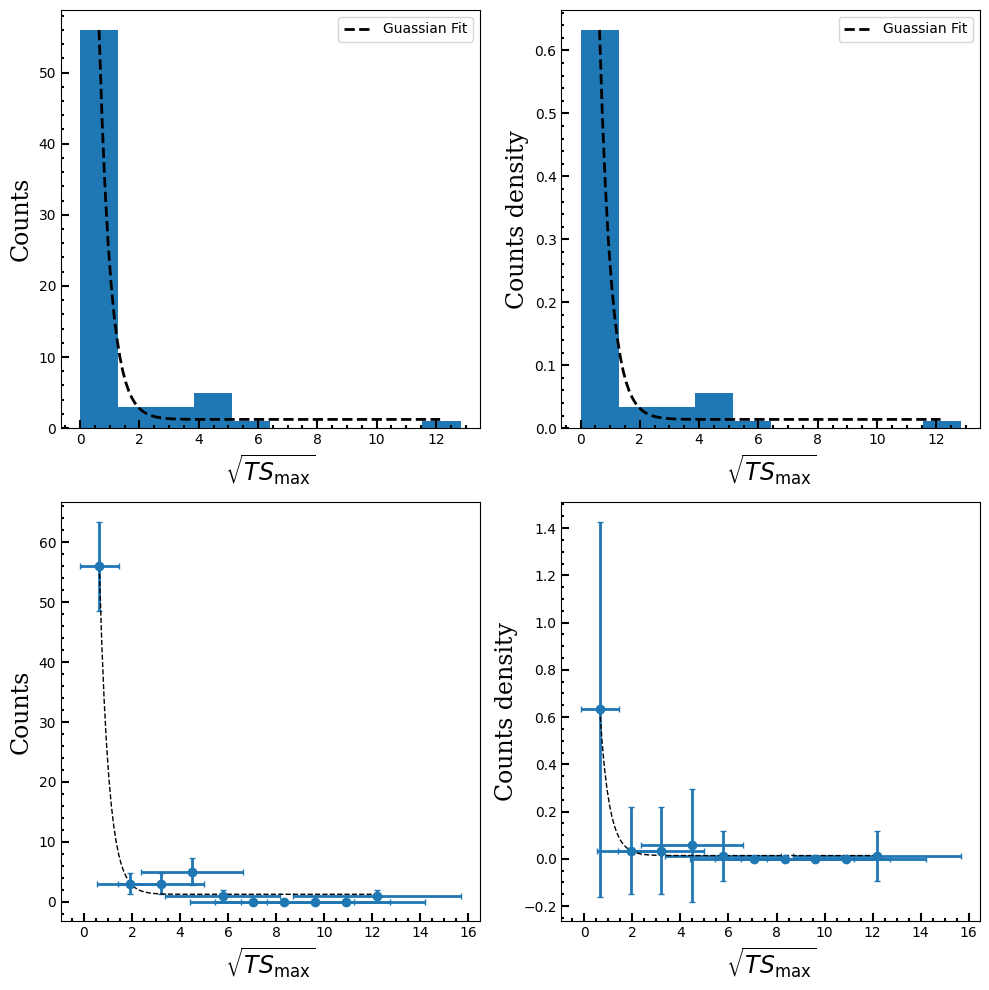

In [16]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator, NullLocator
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 17,
        }
n_bins = 10
fig, axs = plt.subplots(2, 2, tight_layout=True,figsize=(10, 10))
axs[0][0].set_ylabel('Counts',axesfont)
axs[0][0].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)
axs[1][0].set_ylabel('Counts',axesfont)
axs[1][0].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs[0][0].hist(Ts_max_1, bins=n_bins,linewidth=3)
#print(bins,'\n',patches)
xdata=(bins[:-1]+bins[1:])*0.5
ydata=N
xplot=np.arange(min(xdata)-0.00001,max(xdata),0.1)

print(xdata,'\n',ydata)
# We'll color code by height, but you could use any scalar
parameters, covariance = curve_fit(gauss1, xdata, ydata,maxfev=5000000)
# parameters1,covariance1=curve_fit(gauss,xdata, ydata,maxfev=500000)
# fit_A = parameters[0]
# fit_B = parameters[1]

fit_y = gauss1(xplot, *parameters)

# axs[0].plot(xplot, fit_y, '--', label='fit',c='green')
axs[0][0].plot(xplot, fit_y, '--', label='Guassian Fit',c='k',linewidth=2)
axs[1][0].errorbar(xdata, ydata, xerr=np.sqrt(xdata), yerr=np.sqrt(ydata), fmt='o', elinewidth=2,capsize=2)
axs[1][0].plot(xplot, fit_y, '--', label='Guassian Fit',c='k',linewidth=1)
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
# for thisfrac, thispatch in zip(fracs, patches):
#     color = plt.cm.viridis(norm(thisfrac))
#     thispatch.set_facecolor(color)

# We can also normalize our inputs by the total number of counts
N1, bins1, patches1 = axs[0][1].hist(Ts_max_1, bins=n_bins, density=True)
axs[0][1].set_ylabel('Counts density',axesfont)
axs[0][1].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)
axs[1][1].set_ylabel('Counts density',axesfont)
axs[1][1].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)
xdata1=(bins[:-1]+bins[1:])*0.5
ydata1=N1
xplot1=np.arange(min(xdata1)-0.00001,max(xdata1),0.1)
parameters1,covariance1=curve_fit(gauss1,xdata1, ydata1,maxfev=500000)
fit_y1=gauss1(xplot1, *parameters1)

axs[0][1].plot(xplot1, fit_y1, '--', label='Guassian Fit',c='k',linewidth=2)
axs[1][1].errorbar(xdata1, ydata1, xerr=np.sqrt(xdata1), yerr=np.sqrt(ydata1), fmt='o', elinewidth=2,capsize=2)
axs[1][1].plot(xplot1, fit_y1, '--', label='Guassian Fit',c='k',linewidth=1)
# Now we format the y-axis to display percentage
#axs[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))
axs[0][0].tick_params(which='major', width=1.5, length=6,direction='in')
axs[0][0].tick_params(which='minor', width=1.5, length=3,direction='in')
axs[0][1].tick_params(which='major', width=1.5, length=6,direction='in')
axs[0][1].tick_params(which='minor', width=1.5, length=3,direction='in')
axs[1][0].tick_params(which='major', width=1.5, length=6,direction='in')
axs[1][0].tick_params(which='minor', width=1.5, length=3,direction='in')
axs[1][1].tick_params(which='major', width=1.5, length=6,direction='in')
axs[1][1].tick_params(which='minor', width=1.5, length=3,direction='in')
#axs[1].xaxis.set_minor_locator(MultipleLocator(5))
axs[0][0].legend()
# axs[1].xaxis.set_minor_locator(MultipleLocator(5))
axs[0][1].legend()
axs[0][0].xaxis.set_minor_locator(AutoMinorLocator())
axs[0][0].yaxis.set_minor_locator(AutoMinorLocator())
axs[0][0].tick_params(which='minor', length=2, color='k')
# For the minor ticks, use no labels; default NullFormatter.
axs[0][1].xaxis.set_minor_locator(AutoMinorLocator())
axs[0][1].yaxis.set_minor_locator(AutoMinorLocator())
axs[0][1].tick_params(which='minor', length=2, color='k')
axs[1][0].xaxis.set_minor_locator(AutoMinorLocator())
axs[1][0].yaxis.set_minor_locator(AutoMinorLocator())
axs[1][0].tick_params(which='minor', length=2, color='k')
axs[1][1].xaxis.set_minor_locator(AutoMinorLocator())
axs[1][1].yaxis.set_minor_locator(AutoMinorLocator())
axs[1][1].tick_params(which='minor', length=2, color='k')
# axs[1][0].set_xscale('log')
# axs[1][1].set_xscale('log')
# axs[1][0].set_yscale('log')
# axs[1][1].set_yscale('log')
# axs[0][0].set_yscale('log')
# axs[0][1].set_yscale('log')
# axs[0][0].set_xscale('log')
# axs[0][1].set_xscale('log')
fig.savefig('Ts_max_1distr.pdf')

[ 0.6414643   1.92439291  3.20732152  4.49025013  5.77317874  7.05610735
  8.33903596  9.62196457 10.90489318 12.18782179] 
 [56.  3.  3.  5.  1.  0.  0.  0.  0.  1.]


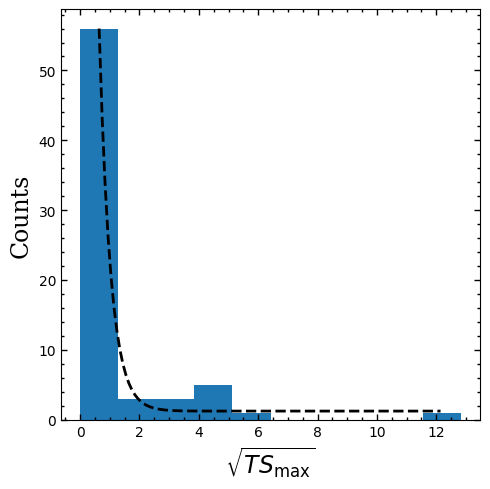

In [35]:
font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 17,
        }
n_bins = 10
fig, axs = plt.subplots(1, 1, tight_layout=True,figsize=(5, 5))
axs.set_ylabel('Counts',axesfont)
axs.set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)
# axs[1][0].set_ylabel('Counts',axesfont)
# axs[1][0].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs.hist(Ts_max_1, bins=n_bins,linewidth=3)
#print(bins,'\n',patches)
xdata=(bins[:-1]+bins[1:])*0.5
ydata=N
xplot=np.arange(min(xdata)-0.00001,max(xdata),0.1)

print(xdata,'\n',ydata)
# We'll color code by height, but you could use any scalar
parameters, covariance = curve_fit(gauss1, xdata, ydata,maxfev=5000000)
# parameters1,covariance1=curve_fit(gauss,xdata, ydata,maxfev=500000)
# fit_A = parameters[0]
# fit_B = parameters[1]

fit_y = gauss1(xplot, *parameters)

# axs[0].plot(xplot, fit_y, '--', label='fit',c='green')
axs.plot(xplot, fit_y, '--', label='Guassian Fit',c='k',linewidth=2)
# axs[1][0].errorbar(xdata, ydata, xerr=np.sqrt(xdata), yerr=np.sqrt(ydata), fmt='o', elinewidth=2,capsize=2)
# axs[1][0].plot(xplot, fit_y, '--', label='Guassian Fit',c='k',linewidth=1)
# fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
# norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
# for thisfrac, thispatch in zip(fracs, patches):
#     color = plt.cm.viridis(norm(thisfrac))
#     thispatch.set_facecolor(color)

# We can also normalize our inputs by the total number of counts
# N1, bins1, patches1 = axs[0][1].hist(Ts_max, bins=n_bins, density=True)
# axs[0][1].set_ylabel('Counts density',axesfont)
# axs[0][1].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)
# axs[1][1].set_ylabel('Counts density',axesfont)
# axs[1][1].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)
# xdata1=(bins[:-1]+bins[1:])*0.5
# ydata1=N1
# xplot1=np.arange(min(xdata1)-0.00001,max(xdata1),0.1)
# parameters1,covariance1=curve_fit(gauss1,xdata1, ydata1,maxfev=500000)
# fit_y1=gauss1(xplot1, *parameters1)

# axs[0][1].plot(xplot1, fit_y1, '--', label='Guassian Fit',c='k',linewidth=2)
# axs[1][1].errorbar(xdata1, ydata1, xerr=np.sqrt(xdata1), yerr=np.sqrt(ydata1), fmt='o', elinewidth=2,capsize=2)
# axs[1][1].plot(xplot1, fit_y1, '--', label='Guassian Fit',c='k',linewidth=1)
# Now we format the y-axis to display percentage
#axs[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))
axs.tick_params(which='major', width=1.5, length=6,direction='in')
axs.tick_params(which='minor', width=1.5, length=3,direction='in')
# axs[0][1].tick_params(which='major', width=1.5, length=6,direction='in')
# axs[0][1].tick_params(which='minor', width=1.5, length=3,direction='in')
# axs[1][0].tick_params(which='major', width=1.5, length=6,direction='in')
# axs[1][0].tick_params(which='minor', width=1.5, length=3,direction='in')
# axs[1][1].tick_params(which='major', width=1.5, length=6,direction='in')
# axs[1][1].tick_params(which='minor', width=1.5, length=3,direction='in')
# #axs[1].xaxis.set_minor_locator(MultipleLocator(5))
# axs[0][0].legend()
# # axs[1].xaxis.set_minor_locator(MultipleLocator(5))
# axs[0][1].legend()
axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())
axs.tick_params(which='minor', length=2,width=1, color='k')
axs.tick_params(which='major', length=4,width=1, color='k')
axs.tick_params(axis='x', which='minor', bottom=True,top=True)
axs.tick_params(axis='x', which='major', bottom=True,top=True)
axs.tick_params(axis='y', which='minor', bottom=True,top=True,right=True)
axs.tick_params(axis='y', which='major', bottom=True,top=True,right=True)
# For the minor ticks, use no labels; default NullFormatter.
# axs[0][1].xaxis.set_minor_locator(AutoMinorLocator())
# axs[0][1].yaxis.set_minor_locator(AutoMinorLocator())
# axs[0][1].tick_params(which='minor', length=2, color='k')
# axs[1][0].xaxis.set_minor_locator(AutoMinorLocator())
# axs[1][0].yaxis.set_minor_locator(AutoMinorLocator())
# axs[1][0].tick_params(which='minor', length=2, color='k')
# axs[1][1].xaxis.set_minor_locator(AutoMinorLocator())
# axs[1][1].yaxis.set_minor_locator(AutoMinorLocator())
# axs[1][1].tick_params(which='minor', length=2, color='k')
# axs[1][0].set_xscale('log')
# axs[1][1].set_xscale('log')
# axs[1][0].set_yscale('log')
# axs[1][1].set_yscale('log')
# axs[0][0].set_yscale('log')
# axs[0][1].set_yscale('log')
# axs[0][0].set_xscale('log')
# axs[0][1].set_xscale('log')
fig.savefig('Ts_single_max1_distr.pdf')

In [6]:
# UNCOMMENT FOR LINEAR BINS
# all_enu = np.linspace(10**11.001, 10**18.999, 1000)
all_enu = e_nu_wall

# enus = 0.5*(all_enu[1:]+all_enu[:-1])
# UNCOMMENT FOR DENSER LOGARITHMIC BINS, optimal nbins is 1e6
enus = np.logspace(11.001, 18.999, int(1e6))
print(all_enu)
print (len(enus))


[1.00000000e+11 1.58489319e+11 2.51188643e+11 3.98107171e+11
 6.30957344e+11 1.00000000e+12 1.58489319e+12 2.51188643e+12
 3.98107171e+12 6.30957344e+12 1.00000000e+13 1.58489319e+13
 2.51188643e+13 3.98107171e+13 6.30957344e+13 1.00000000e+14
 1.58489319e+14 2.51188643e+14 3.98107171e+14 6.30957344e+14
 1.00000000e+15 1.58489319e+15 2.51188643e+15 3.98107171e+15
 6.30957344e+15 1.00000000e+16 1.58489319e+16 2.51188643e+16
 3.98107171e+16 6.30957344e+16 1.00000000e+17 1.58489319e+17
 2.51188643e+17 3.98107171e+17 6.30957344e+17 1.00000000e+18
 1.58489319e+18 2.51188643e+18 3.98107171e+18 6.30957344e+18
 1.00000000e+19]
1000000


In [7]:
enus_bin_indices = np.zeros(len(enus), dtype=np.int64)

for i in prange(len(enus)):
    enus_bin_indices[i] = np.digitize(enus[i], e_nu_wall) -1
print (len(e_nu_wall))

41


In [8]:
msdec
print(dec_nu)

[-90.   -73.74 -66.93 -61.64 -57.14 -53.13 -49.46 -46.05 -42.84 -39.79
 -36.87 -34.06 -31.33 -28.69 -26.1  -23.58 -21.1  -18.66 -16.26 -13.89
 -11.54  -9.21  -6.89  -4.59  -2.29   0.     2.29   4.59   6.89   9.21
  11.54  13.89  16.26  18.66  21.1   23.58  26.1   28.69  31.33  34.06
  36.87  39.79  42.84  46.05  49.46  53.13  57.14  61.64  66.93  73.74
  90.  ]


In [9]:
msdec_bin_indices = np.zeros(p, dtype=np.int64)
for i in prange(p):
    msdec_bin_indices[i] = np.digitize(msdec[i], dec_nu) - 1
print(len(dec_nu))

51


In [10]:
gamma_arr = [-2, -2.2, -2.53, -3]
phio = np.logspace(-38, -26, 1000) #CHANGING TO LINEAR BINS RESULTS IN STRAIGHT LINES

# print("\nNumber of threads: ", num_threads)
print("\nNumber of energy bins: ", len(enus))
print("\nNumber of phi bins: ", len(phio))
print("\nCalculating weights...\n\n")


Number of energy bins:  1000000

Number of phi bins:  1000

Calculating weights...



In [105]:
enus

array([1.00230524e+11, 1.00232370e+11, 1.00234216e+11, ...,
       9.97663317e+18, 9.97681690e+18, 9.97700064e+18])

In [9]:
eareaa = [i.astype(np.float64) for i in earea]
eareaa = np.asfarray(eareaa, dtype=np.float64)
eareaa[0][0]
earea2 = np.asfortranarray(earea)
earea2 = earea2[0].astype(np.float64)

In [117]:
print(msdec_bin_indices)

[47 32 48 ... 25 31 34]


In [11]:
@vectorize(['float64(int64, float64, int64)'], nopython=True, target='parallel')
def psr_wt_sing_gamma(psrno,gamma, season):

    tt_upt = t_upt[season]
    l = msdec_bin_indices[psrno]
    wt_ac_temp = np.zeros(len(enus), dtype=np.float64)
    for i in prange(len(enus)):
        wt_ac_temp[i] = np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * enus[i]**gamma)   


    return np.trapz(wt_ac_temp, enus)


In [22]:
wt_vec = psr_wt_sing_gamma(range(p), -1, 0)
print(wt_vec)

[2.83650278e+13 5.86577806e+14 2.04760708e+13 ... 1.90869204e+16
 8.12870622e+14 3.75424443e+14]


In [12]:
w_models = np.column_stack([np.ones(p), 1/(msdist**2), mss1400]).T.astype(np.float64)
sum_wt_model = [1, np.sum(1/(msdist**2)), np.sum(mss1400)]
print(w_models.shape)
print(sum_wt_model)

(3, 3389)
[1, inf, 5058.129999999999]


/tmp/ipykernel_2155/851389087.py:1: RuntimeWarning: divide by zero encountered in divide
  w_models = np.column_stack([np.ones(p), 1/(msdist**2), mss1400]).T.astype(np.float64)
/tmp/ipykernel_2155/851389087.py:2: RuntimeWarning: divide by zero encountered in divide
  sum_wt_model = [1, np.sum(1/(msdist**2)), np.sum(mss1400)]


In [14]:


print(w_models.shape)
altier_path = [os.getcwd() + '/pickle/', os.getcwd() + '/../pickle/']
print(os.listdir(altier_path[0]))

(3, 3389)
['all_TSS_100000_bins_C_wt_all_psr_wmod1.pkl1', 'ns_hat_wt_wt_gamma_-1.txt', 'ns_hat_wt_wt_gamma_-2.2.txt', 'ns_all_ws_100000_bins_C_wt_all_psr_wmod1.pkl1', 'all_Si_ws_g_s_100000_bins_C_wt_all_psr_wmod1.pkl1', 'ns_hat_wt_wt_gamma_-2.5.txt', 'wt_acc_100000_bins_C_wt_all_psr_wmod1.pkl1', 'ns_hat_wt_wt_gamma_-3.txt', 'all_Bi.pkl']


In [14]:
altier_path = [os.getcwd() + '/pickle/', os.getcwd() + '/../pickle/']
if f'wt_acc_{len(enus)}_bins.pkl' in os.listdir(altier_path[0]):# or f'wt_acc.pkl_{len(enus)}' in os.listdir(altier_path[1]):
    print("Loading wt_acc from pickle")
    # try:
    #     wt_acc = pickle.load(altier_path[1] + f'wt_acc.pkl_{len(enus)//2}_bins')
    # except:
    with open(altier_path[0] + f'wt_acc_{len(enus)}_bins.pkl', 'rb') as f:
        wt_acc = pickle.load(f)
    
    
    print("Loaded wt_acc from pickle with nbins= ", len(enus))

else:
    print("Calculating wt_acc for all pulsars and seasons and gamma")
    wt_acc = []
    for gamma in prange(len(gamma_arr)):
        wt_allpsr = []
        for season in tqdm(prange(10)):
            # tmp = []
            # for psrno in prange(p):
                # w_model = w_models[psrno]
                # tmp.append(psr_wt_sing_gamma(psrno, gamma_arr[gamma], season))
                # tmp.append(trapz_numba(psr_wt_sing_e_gamma(psrno, enus, gamma_arr[gamma], season), enus))

            wt_allpsr.append(np.array(psr_wt_sing_gamma(prange(p), gamma_arr[gamma], season), dtype=np.float64))
            # tmp = []
        wt_acc.append(wt_allpsr)
        wt_allpsr = []
        
    wt_acc = np.asfarray(wt_acc, dtype=np.float64)
    with open(altier_path[0] + f'wt_acc_{len(enus)}_bins.pkl', 'wb') as f:
        pickle.dump(wt_acc, f)
    print("Calculated wt_acc for all gamma-ray sources and seasons and gamma")

Loading wt_acc from pickle
Loaded wt_acc from pickle with nbins=  1000000


In [15]:
print(wt_acc.shape)

(4, 10, 3389)


In [16]:
season_walls = np.asarray([0, 36900, 143911, 237044, 373288, 486146, 608687, 735732, 865043, 988700, 1134450])
season_widts= np.diff(season_walls)
print (season_widts)

[ 36900 107011  93133 136244 112858 122541 127045 129311 123657 145750]


In [17]:
#Compute the signal PDF for all neutrinos as per eqns 6, 7 and weights as per eqn 8 of 2205.15963

@njit(nogil=True)
def S_ijk(nu): 

    '''
    Calculates S_ij as in EQN 7 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample
        
    
    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''
    ang2 = hvovec(msra, msdec, icra[nu], icdec[nu], rad=True) ** 2      #rad**2
    sg = np.deg2rad(icang[nu]) ** 2                                     #rad**2
    return np.divide(np.exp(-1 * np.divide(ang2, 2*sg)), (2 * np.pi * sg))      #1/rad**2


@njit(nogil=True)
def S_ik(nu, weight, w_models, gamma_index, ws):

    '''
    
    Calculates S_i as in EQN 8 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample

    normalized_wt : array
        Normalized weights of the pulsars


    gamma_index : int
        Index of the gamma value in the gamma array

    ws : int
        Index of the weight model

    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino

    '''

    # si_sing_season_g =
    # for i in prange(p):
        # sij = S_ijk(nu)
        # np.sum(np.multiply(sij, normalized_wt[i][gamma_index][season]))      #1/rad**2



    sij = S_ijk(nu)
    season = 0
    for i in range(10):
        if season_walls[i] <= nu and nu < season_walls[i+1]:
            season = i
            break

    return np.sum(np.multiply(sij, np.multiply(w_models[ws], weight[gamma_index][season])/np.sum(np.multiply(w_models[ws], weight[gamma_index][season]))))      #1/rad**2


In [18]:
@njit(parallel=True, nogil=True)
def Sik_sing_s_g(gamma_index, ws):#, wt_acc=wt_acc, w_models=w_models):
    '''
    Calculates S_i as in EQN 8 of 2205.15963
    ----------

    Parameters
    ----------
    weight : array
         weights of the pulsars

    season : int
        Season of the neutrino

    gamma_index : int
        Index of the gamma value in the gamma array

    ws : int
        Index of the weight model

    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''



    tmp = []
    if ws == -1: #No weights
        for nu in prange(len(icra)):
            tmp.append(np.sum(S_ijk(nu)))
        return np.array(tmp, dtype=np.float64)

    for nu in prange(len(icra)):
        tmp.append(S_ik(nu, wt_acc, w_models, gamma_index, ws))
    return np.array(tmp, dtype=np.float64)

In [19]:
#Pickle
if os.path.isfile(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins.pkl'):
    print("Loading all_Si_ws_g_s from pickle")
    with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins.pkl', 'rb') as f:
        all_Si_ws_g_s = pickle.load(f)
    print("Loaded all_Si_ws_g_s from pickle with nbins =", len(enus))
else:


    print("\nCalculating S_i for all neutrinos and gammas and weighting schemes...\n")

    all_Si_ws_g_s = []
    tmp = []
    tmp_wt_acc = []
    tmp_wt_acc_w_dist = []
    tmp_wt_acc_w_s1400 = []

    for gamma_index in tqdm(prange(4)):
        # for season in tqdm(prange(10)):
        tmp.append(Sik_sing_s_g(gamma_index, -1))
        tmp_wt_acc.append(Sik_sing_s_g(gamma_index, 0))
        tmp_wt_acc_w_dist.append(Sik_sing_s_g(gamma_index, 1))
        tmp_wt_acc_w_s1400.append(Sik_sing_s_g(gamma_index, 2))


    all_Si_ws_g_s.append([tmp, tmp_wt_acc, tmp_wt_acc_w_dist, tmp_wt_acc_w_s1400])
    tmp = []
    tmp_wt_acc = []
    tmp_wt_acc_w_dist = []
    tmp_wt_acc_w_s1400 = []
    all_Si_ws_g_s = np.asfarray(all_Si_ws_g_s[0])

    print("Calculated S_i for all neutrinos and gammas and weighting schemes")
    #Save to pickle
    with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins.pkl', 'wb') as f:
        pickle.dump(all_Si_ws_g_s, f)




Calculating S_i for all neutrinos and gammas and weighting schemes...


100%|██████████| 4/4 [05:33<00:00, 83.37s/it]

Calculated S_i for all neutrinos and gammas and weighting schemes


In [23]:
# @jit(nopython=True)
@vectorize(['float64(int64, int64)'], nopython=True,target='parallel')
def Bi_single_compute(nu,i,cone=5):

    '''
    Calculates B_i as in EQN 9 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino from IceCube sample
    cone : float
        Cone angle in degrees.
    

    Returns
    -------
    float
        Returns the background PDF for the {nu}th neutrino
    '''

    # count = np.sum(np.abs(np.subtract(icdec, icdec[nu])) <= cone)
    count=0
    for i in prange(len(icdec)):
        if abs(icdec[i] - icdec[nu]) <= cone:
            count+=1
    binwidth = (np.sin(np.deg2rad(icdec[nu] + cone)) - np.sin(np.deg2rad(icdec[nu] - cone)))*2*np.pi
    return count/(binwidth * N_ic)           #No units or sr**-1

In [24]:
#Pickle
if os.path.isfile(altier_path[0] + f'all_Bi.pkl'):
    print("Loading all_Bi from pickle...")
    with open(altier_path[0] + f'all_Bi.pkl', 'rb') as f:
        all_Bi = pickle.load(f)
    print("Loaded all_Bi from pickle")
else:
    print("\nCalculating Bi for all neutrinos\n")
    all_Bi = Bi_stacked_compute(np.arange(lnu), 5)
    # all_Bi+=1e-90
    print("\nCalculated Bi for all neutrinos")
    #Save to pickle
    with open(altier_path[0] + f'all_Bi.pkl', 'wb') as f:
        pickle.dump(all_Bi, f)

Loading all_Bi from pickle...
Loaded all_Bi from pickle


 '''
    This function returns the number of signal events for a single pulsar as in EQN3 of 2205.15963
    -------------------

    Parameters
    ----------
    dec : float
        The declination of the pulsar in radians
    
    enu : float
        The neutrino energy in eV

    gamma : float
        The spectral index of the neutrino flux

    phi0 : float (optional)
        The normalization constant of the neutrino flux

    season : int (optional)
        The IceCube season number
    
    Returns
    -------
    float
        The number of signal events for the given parameters
    '''


In [31]:
type(msdec_bin_indices[0])

numpy.int64

In [32]:
arr = np.zeros(10, dtype=np.float64)

In [71]:
t_upt

array([35318439.34329611, 32497618.3151043 , 29902901.99932829,
       31745765.00015999, 32053797.00057632, 33098838.99984006,
       34788962.99980783, 33936928.00012794, 31302372.99945645,
       36107635.00003202])

In [26]:
#generates ns^ for a single pulsar a single season and a single energy


# @vectorize(['float64(int64, float64, int64)'], nopython=True, target='parallel')
# def psr_wt_sing_gamma(psrno,gamma, season):

#     tt_upt = t_upt[season]
#     l = msdec_bin_indices[psrno]
#     wt_ac_temp = np.zeros(len(enus), dtype=np.float64)
#     for i in prange(len(enus)):
#         wt_ac_temp[i] = np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * enus[i]**gamma)


#     return np.trapz(wt_ac_temp, enus)
# @njit
# @vectorize(['float64(float64, float64, float64, int64)'], target='parallel')
@vectorize(['float64(int64, float64, float64, int64)'], nopython=True, target='parallel')
def ns_singleseason_sing_psr_HAT(psrno,gamma, phi0, season):
   

    tt_upt = t_upt[season]
    # if enu <= 1e11 or enu >= 1e19:
    #     return 0.0
    # else:
        # k=0
    l = msdec_bin_indices[psrno]
        # for i in range(0, len(e_nu_wall)):
        #     if e_nu_wall[i] <= enu and e_nu_wall[i+1] > enu:
        #         k=i
        #         break

        # for j in range(0, len(dec_nu)):
        #     if dec_nu[j] <= dec and dec_nu[j+1] > dec:
        #         l=j
        #         break
    ns_temp = np.zeros(len(enus), dtype=np.float64)
    for i in prange(len(enus)):
        ns_temp[i] += np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * phi0 * (enus[i]/(10**14))**gamma)
    # temp_ea = np.asarray(earea[ea_season(season)])[l*40 + k]
    # return tt_upt * temp_ea * phi0 * ((enu/(10**14))**gamma)     #in s cm2 eV

    return np.trapz(ns_temp, enus)     #in s cm2 eV


In [34]:
msdec

array([62.26927778, 47.77594444, -9.16630556, ..., -6.16663861,
       61.92967917,  0.85265833])

In [27]:
def ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights(gamma, e_nus=enus, phi0=1):
    ns_hat = 0
    ns_hat_wt = 0
    ns_hat_wt_dist = 0
    ns_hat_wt_s1400 = 0
    for season in tqdm(prange(10)):
        # for psr in prange(p):
            # wt = all_weights[0][gamma_arr.index(gamma)][psr][ea_season(season)]
        wt_sum = np.sum(wt_acc[gamma_arr.index(gamma)][season])

        wt = wt_acc[gamma_arr.index(gamma)][season]
        ns_hat = ns_singleseason_sing_psr_HAT(prange(p), gamma, phi0, season)
        # ns_hat_wt += np.dot(wt, nsop)
        # ns_hat_wt_dist += np.dot(wt/msdist[prange(p)]**2, nsop)
            # nsop = ns_singleseason_sing_psr_HAT(msdec[psr], e_nus, gamma, phi0, season)
            
            # ns_hat += np.trapz(nsop, x=e_nus)
        
    #         ns_hat_wt += wt * np.trapz(nsop, x=e_nus)
    #         ns_hat_wt_dist += wt * np.trapz(nsop, x=e_nus) / (msdist[psr]**2)
    #         ns_hat_wt_s1400 += wt * np.trapz(nsop, x=e_nus) * mss1400[psr]
    # return np.array([ns_hat, ns_hat_wt, ns_hat_wt_dist, ns_hat_wt_s1400], dtype=np.float64)

        ns_hat_wt += np.dot((wt/wt_sum),  ns_hat)
        ns_hat_wt_dist += np.dot(wt * w_models[1]/ np.sum(np.multiply(wt_acc[gamma_arr.index(gamma)][season], w_models[1])) , ns_hat)
        ns_hat_wt_s1400 += np.dot(wt * w_models[2]/ np.sum(np.multiply(wt_acc[gamma_arr.index(gamma)][season], w_models[2])), ns_hat)
    return np.array([np.sum(ns_hat), ns_hat_wt, ns_hat_wt_dist, ns_hat_wt_s1400], dtype=np.float64)

In [28]:
#Pickle
arr = []
if os.path.isfile(altier_path[0] + f'ns_all_ws_{len(enus)}_bins.pkl'):
    print("Loading ns_hat from pickle...")
    with open(altier_path[0] + f'ns_all_ws_{len(enus)}_bins.pkl', 'rb') as f:
        arr = pickle.load(f)
    print("Loaded ns_hat from pickle with nbins =", len(enus))
else:
    print("\nCalculating ns_HAT for all gamma and weighting schemes...\n")

    arr=[]
    for gamma in prange(len(gamma_arr)):
        tmp = ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights(gamma_arr[gamma])
        np.savetxt('outputs/ns_hat_wt_wt_gamma_{}.txt'.format(gamma_arr[gamma]), tmp)
        arr.append(tmp)
        tmp = []

    arr = np.array(arr, dtype=np.float64)
    with open(altier_path[0] + f'ns_all_ws_{len(enus)}_bins.pkl', 'wb') as f:
        pickle.dump(arr, f)
    print("\nCalculationed ns_HAT for all gamma and weighting schemes")


Calculating ns_HAT for all gamma and weighting schemes...


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_2155/2468739112.py:25: RuntimeWarning: invalid value encountered in divide
  ns_hat_wt_dist += np.dot(wt * w_models[1]/ np.sum(np.multiply(wt_acc[gamma_arr.index(gamma)][season], w_models[1])) , ns_hat)
100%|██████████| 10/10 [03:43<00:00, 22.34s/it]


Calculationed ns_HAT for all gamma and weighting schemes


In [35]:
arr

array([[3.52864701e+31, 1.64348155e+29,            nan, 1.43286227e+29],
       [4.29254469e+31, 2.12101932e+29,            nan, 1.97836837e+29],
       [9.09734829e+31, 4.71885376e+29,            nan, 4.68667418e+29],
       [4.99686265e+32, 2.64971787e+30,            nan, 2.73604535e+30]])

In [37]:
@njit(parallel=True, nogil=True)
def season_nu(nu):
    for i in prange(10):
        if nu >= season_walls[i] and nu < season_walls[i+1]:
            return i

t2mp = all_Si_ws_g_s[0][0]
nsa = 50
@njit(nogil=True)
def TS_for_all_psrs2(nsa):  
    return Ts_arr2(nsa, t2mp, all_Bi, Ns) 

TS_for_all_psrs2(nsa)

In [38]:
@jit(nopython=True)
def Pr(x, Ns, S, B):
    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))



@njit(nogil=True)
def TS_st_vec(x, S, B, Ns):
    nsN = x/Ns
    pr = np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))
    return np.sum(np.asfarray(2*np.log(pr/B)))

lnu = 1134450
Ns = lnu#np.count_nonzero(nuind+1)


TS_st_vec(0.5e6, all_Si_ws_g_s[0][0], all_Bi, Ns)

In [39]:
phio = np.logspace(-38, -20, 1000)
print(phio)

[1.00000000e-38 1.04236067e-38 1.08651577e-38 1.13254132e-38
 1.18051653e-38 1.23052400e-38 1.28264983e-38 1.33698374e-38
 1.39361927e-38 1.45265393e-38 1.51418933e-38 1.57833141e-38
 1.64519059e-38 1.71488197e-38 1.78752553e-38 1.86324631e-38
 1.94217468e-38 2.02444651e-38 2.11020343e-38 2.19959307e-38
 2.29276931e-38 2.38989257e-38 2.49113003e-38 2.59665597e-38
 2.70665207e-38 2.82130768e-38 2.94082017e-38 3.06539530e-38
 3.19524751e-38 3.33060034e-38 3.47168682e-38 3.61874981e-38
 3.77204249e-38 3.93182876e-38 4.09838367e-38 4.27199397e-38
 4.45295851e-38 4.64158883e-38 4.83820966e-38 5.04315949e-38
 5.25679112e-38 5.47947234e-38 5.71158648e-38 5.95353313e-38
 6.20572881e-38 6.46860766e-38 6.74262224e-38 7.02824426e-38
 7.32596543e-38 7.63629826e-38 7.95977700e-38 8.29695852e-38
 8.64842328e-38 9.01477631e-38 9.39664831e-38 9.79469667e-38
 1.02096066e-37 1.06420924e-37 1.10928986e-37 1.15628013e-37
 1.20526094e-37 1.25631660e-37 1.30953502e-37 1.36500781e-37
 1.42283046e-37 1.483102

In [40]:
print('\nCALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS\n')

all_TSS = []
for ws in prange(4):
    tmpp = []
    print("ws = {}".format(ws))
    for gamma in prange(len(gamma_arr)):
        print("gamma = {}".format(gamma))
        # tmp = np.zeros(len(phio))
        # for season in tqdm(range(10)):
        t2mp = np.asfarray(all_Si_ws_g_s[ws][gamma])
        @njit(nogil=True)
        def TS_for_all_psrs2(nsa):  
            return TS_st_vec(nsa, t2mp, all_Bi, Ns)      #No units
        temp = []
        for phi in tqdm(prange(len(phio))):
            temp.append(TS_for_all_psrs2(arr[gamma][ws]*phio[phi]))
        tmpp.append(temp)
        temp = []
    all_TSS.append(tmpp)
    tmpp = []

print('\nCALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS')


CALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS

ws = 0
gamma = 0


100%|██████████| 1000/1000 [00:10<00:00, 96.73it/s]


gamma = 1


100%|██████████| 1000/1000 [00:10<00:00, 99.60it/s]


gamma = 2


100%|██████████| 1000/1000 [00:10<00:00, 98.68it/s]


gamma = 3


100%|██████████| 1000/1000 [00:10<00:00, 96.38it/s]


ws = 1
gamma = 0


100%|██████████| 1000/1000 [00:08<00:00, 122.85it/s]


gamma = 1


100%|██████████| 1000/1000 [00:08<00:00, 121.74it/s]


gamma = 2


100%|██████████| 1000/1000 [00:08<00:00, 117.96it/s]


gamma = 3


100%|██████████| 1000/1000 [00:08<00:00, 122.59it/s]


ws = 2
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 141.61it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 140.27it/s]


gamma = 2


100%|██████████| 1000/1000 [00:07<00:00, 140.22it/s]


gamma = 3


100%|██████████| 1000/1000 [00:07<00:00, 141.59it/s]


ws = 3
gamma = 0


100%|██████████| 1000/1000 [00:07<00:00, 126.48it/s]


gamma = 1


100%|██████████| 1000/1000 [00:07<00:00, 125.19it/s]


gamma = 2


100%|██████████| 1000/1000 [00:08<00:00, 124.97it/s]


gamma = 3


100%|██████████| 1000/1000 [00:07<00:00, 125.55it/s]


CALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS


### $N \approx 10^6$

In [42]:
all_TSS = np.array(all_TSS, dtype=np.float64)
all_TSS.shape

(4, 4, 1000)

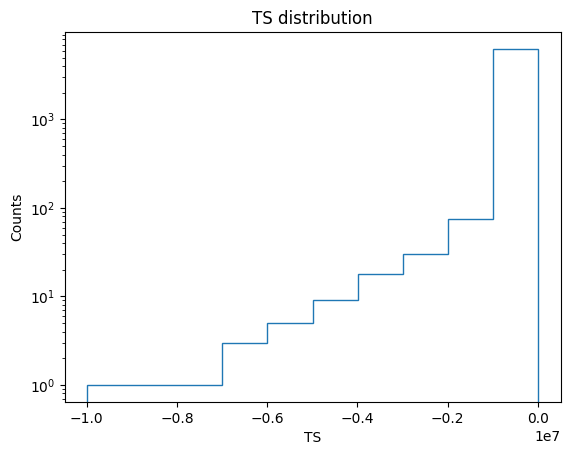

In [48]:
# for i in range(1, len(all_TSS)):
plt.figure()
histdetails = plt.hist(np.ravel(all_TSS[1:]), bins=10, density=False, histtype='step')
# plt.ylim(0, 1000)
plt.yscale('log')
plt.xlabel('TS')
plt.ylabel('Counts')
plt.title('TS distribution')
plt.show()

histdetails = np.histogram(np.ravel(all_TSS[1:]), bins=10)

In [49]:
histdetails

(array([1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 5.000e+00, 9.000e+00,
        1.800e+01, 3.000e+01, 7.500e+01, 6.257e+03]),
 array([-9.98903755e+06, -8.99013251e+06, -7.99122746e+06, -6.99232241e+06,
        -5.99341737e+06, -4.99451232e+06, -3.99560728e+06, -2.99670223e+06,
        -1.99779719e+06, -9.98892142e+05,  1.29038750e+01]),
 [<matplotlib.patches.Polygon at 0x7f88cbc02af0>])

In [45]:
len(np.ravel(all_TSS[1:]))

12000

np.count_nonzero(np.ravel(all_TSS[1:])> )

In [46]:
all_TSS = np.array(all_TSS, dtype=np.float64)

In [47]:
all_TSS.shape

(4, 4, 1000)

In [48]:
for w in range(1,4):
    for g in range(len(gamma_arr)):
        print(min(all_TSS[w][g]), max(all_TSS[w][g]))
        # np.savetxt(f'TS_w{w}_g{g}.txt', all_TSS[w][g])
        
    print('wt\n')

with open(altier_path[0] + f'all_TSS_{len(enus)}_bins.pkl', 'wb') as f:
    pickle.dump(all_TSS, f)

-6057251.366320607 12.156029323378263
-5804441.418755395 14.844657652002391
-5992055.274334782 16.10839920845393
-5962949.590941089 15.982653949210043
wt

-8611100.99949178 1.2955535383705152
-6125012.599336783 3.1780334067582507
-9060415.976970289 4.667547026372957
-7217284.656668596 4.901525793335741
wt

-8380247.223308682 4.653394559824417
-7127537.311617021 6.824156252534279
-10052884.960864566 7.381386412963184
-7110119.631885988 7.272296852698757
wt


In [50]:
#Plotting

all_TSS = np.asarray(all_TSS)
gamma_arr = np.asarray(gamma_arr)

all_e_UL = []
e_decade = [1e13, 1e14, 1e15, 1e16, 1e17]
for e_UL in e_decade:
    e2dfde = []

    for gamma in prange(len(gamma_arr)):
        temp = []
        for phi in range(len(phio)):
            temp.append( e_UL**2 * dfde(e_UL, gamma_arr[gamma], phio[phi]))        #in eV
        e2dfde.append(temp)
    e2dfde = np.asarray(e2dfde)

    all_e_UL.append(e2dfde)
mark = ['^', 'o', 's', 'd']

In [69]:
for i in all_e_UL:
    print(i)
    print('next energy bin')

[[1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
  9.59360829e+07 1.00000000e+08]
 [1.58489319e-10 1.65203034e-10 1.72201145e-10 ... 1.45869322e+08
  1.52048445e+08 1.58489319e+08]
 [3.38844156e-10 3.53197823e-10 3.68159521e-10 ... 3.11863080e+08
  3.25073810e+08 3.38844156e+08]
 [1.00000000e-09 1.04236067e-09 1.08651577e-09 ... 9.20373200e+08
  9.59360829e+08 1.00000000e+09]]
next energy bin
[[1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
  9.59360829e+07 1.00000000e+08]
 [1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
  9.59360829e+07 1.00000000e+08]
 [1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
  9.59360829e+07 1.00000000e+08]
 [1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
  9.59360829e+07 1.00000000e+08]]
next energy bin
[[1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
  9.59360829e+07 1.00000000e+08]
 [6.30957344e-11 6.57685123e-11 6.85545108e-11 ... 5.80716230e+07
  6.05315

In [73]:

all_e_UL=np.asarray(all_e_UL)

In [75]:
print(all_e_UL.shape)

(5, 4, 1000)


In [51]:
all_TSS.shape

(4, 4, 1000)

In [52]:
for w in range(1, 4):
    for g in range(1, 4):
        print(phio[np.argmax(all_TSS[w][g])])

2.543345761304638e-23
9.396648314954749e-24
1.4526539259467783e-24
2.3408272761782943e-23
8.296958520834915e-24
1.2305240043592616e-24
1.61141427725301e-23
5.711586478126447e-24
8.470868266557419e-25


In [53]:
max(all_TSS[1][2])

16.10839920845393

In [54]:
tete = np.float64('2.543345761304638e-23 9.396648314954749e-24 1.4526539259467783e-24 2.3408272761782943e-23 8.296958520834915e-24 1.2305240043592616e-24 1.61141427725301e-23 5.711586478126447e-24 8.470868266557419e-25'.split(' '))

In [55]:
tete[2::3].mean()

1.1767549189872607e-24

In [65]:
# e2dfde = all_e_UL[1][2]
# dist_g25 = interp.interp1d(all_TSS[1][2], e2dfde/1e9)

# print(dist_g25(-3.84))

all_UL = []
for ws in range(1,4):
    ul_all_gamma = []
    for gamma in prange(len(gamma_arr)):
        temp = []
        for i in all_e_UL:
            #print(len(all_TSS[ws][gamma]))
            print(len(i[gamma]/1e9))
            dist_g = interp.interp1d(all_TSS[ws][gamma], i[gamma]/1e9)
            temp.append(dist_g(-3.84))

        ul_all_gamma.append(temp)
    all_UL.append(ul_all_gamma)

1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


In [14]:
# plt.style.use('default')
font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 17,
        }

In [59]:
e2dfde = all_e_UL[1]


fig, axs = plt.subplots(1,3, figsize=(18, 6))

for gamma in [ 1, 2, 3]:#range(4):
    
    for i in range(3):
        axs[i].plot(e2dfde[gamma]/1e9, all_TSS[i+1][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]), lw=2.2)# + ' with wt')    #in GeV

    

axs[0].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = 1}}$', fontdict=smallerfont)
axs[1].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = \dfrac{1}{d_{DM}^2}}}$' , fontdict=smallerfont)
axs[2].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = s_{1400}}}$', fontdict=smallerfont)


for i in range(3):
    
    axs[i].legend(prop={'size':14}, framealpha=0, loc='lower left')
    axs[i].hlines(-3.84, 1e-20, 1e-5, linestyles='dashed', lw=2.2, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$', color='lightcoral')
    axs[i].set_xscale('log')
    axs[i].set_xlabel('$\mathsf{\mathbf{E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}}}$ at 100 TeV ($\mathsf{\mathbf{GeV}}$ $\mathsf{\mathbf{s^{-1}}}$ $\mathsf{\mathbf{cm^{-2}}}$ $\mathsf{\mathbf{sr^{-1}}}$)', fontdict=axesfont)
    axs[i].set_ylabel('TS', fontdict=axesfont, fontsize=20)
    axs[i].xaxis.set_tick_params(labelsize=15)
    axs[i].yaxis.set_tick_params(labelsize=15)
    
    axs[i].set_ylim(-220, 90)
    axs[i].set_xlim(0.95e-19, 1e-6)

plt.suptitle('TS vs Total Neutrino Flux at 100 TeV', fontweight='bold', fontsize=20, fontfamily='serif')

plt.tight_layout()
plt.savefig(f'outputs/TS_vs_E2dfde_all_w_model_bins={len(enus)}.png')
# plt.show()
print(f'\nTS_vs_E2dfde_all_w_model_bins={len(enus)}.png\nDONE')

NameError: name 'all_e_UL' is not defined

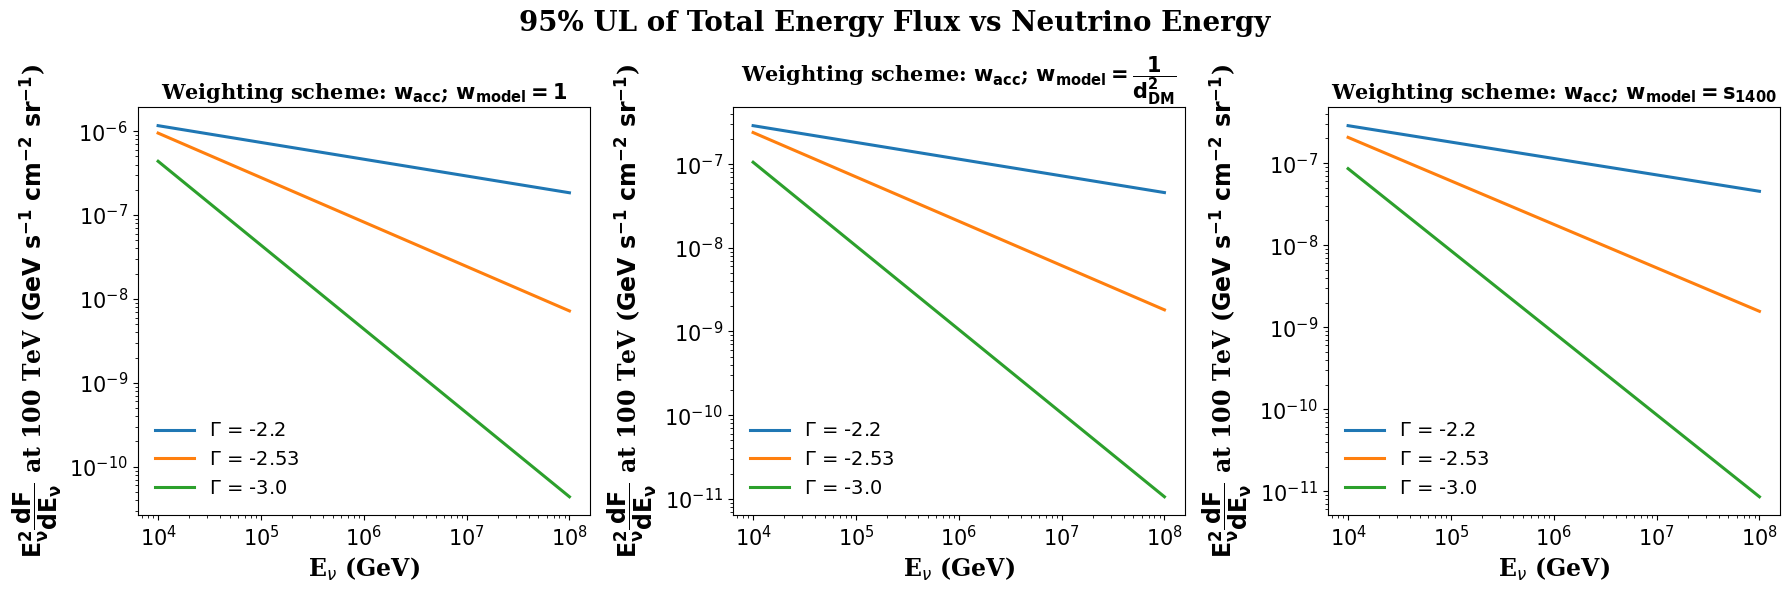

In [58]:
#SIMILAR PLOTS FOR 95% UPPER LIMIT 
fig, axs = plt.subplots(1,3, figsize=(18, 6))



for i in range(3):
    for gamma in range(1, len(gamma_arr)):

        axs[i].plot(np.divide(e_decade, 1e9), np.multiply(all_UL[i][gamma], 3), label='$\Gamma$ = ' + str(gamma_arr[gamma]), lw=2.2, ls='-')# + ' with wt')    #in GeV

    
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlabel('E$_{\u03BD}$ (GeV)', fontdict=axesfont)
    axs[i].set_ylabel('$\mathsf{\mathbf{E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}}}$ at 100 TeV ($\mathsf{\mathbf{GeV}}$ $\mathsf{\mathbf{s^{-1}}}$ $\mathsf{\mathbf{cm^{-2}}}$ $\mathsf{\mathbf{sr^{-1}}}$)', fontdict=axesfont)
    axs[i].xaxis.set_tick_params(labelsize=15)
    axs[i].yaxis.set_tick_params(labelsize=15)
    
    axs[i].legend(prop={'size':14}, framealpha=0, loc='lower left')


axs[0].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = 1}}$', fontdict=smallerfont)
axs[1].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = \dfrac{1}{d_{DM}^2}}}$' , fontdict=smallerfont)
axs[2].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = s_{1400}}}$', fontdict=smallerfont)


plt.suptitle('95% UL of Total Energy Flux vs Neutrino Energy', fontweight='bold', fontsize=20, fontfamily='serif')
plt.tight_layout()
plt.savefig(f'outputs/UL_all_w_model_bins={len(enus)}.png')
plt.show()


In [59]:
# e2dfde = all_e_UL[1]
# plttitles = ['$w_{acc}$ and $w_{model} = 1$', '$w_{acc}$ and $w_{model} = \dfrac{1}{d_{DM}^2}$', '$w_{acc}$ and $w_{model} =  w_{s1400}$']

#         # print(st.t.interval(0.95, len(all_TSS[i][j])-1, loc=np.mean(all_TSS[i][j]), scale=st.sem(all_TSS[i][j])))
# for i in range(1, 4):
#     plt.figure(figsize=(8, 6))
#     for j in range(1, len(gamma_arr)):
#         plt.plot(e2dfde[j]/1e9, all_TSS[i][j], label='$\Gamma$ = ' + str(gamma_arr[j]), lw=0.8)
#         # ci = st.t.interval(0.95, len(all_TSS[i][j])-1, loc=np.mean(all_TSS[i][j]), scale=st.sem(all_TSS[i][j]))
#         # plt.hlines(ci, 1e-19, 1e-6, colors='k', linestyles='dashed', lw=0.5, ls='-.', label="95% CI "+ '$\Gamma$ = ' + str(gamma_arr[j]))

#     plt.hlines(-3.84, 1e-19, 1e-6, linestyles='dashed', lw=0.7, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$')
#     # plt.vlines(dist_g25(-3.84), -120, 50, linestyles='dashed', lw=0.5, ls='-.')
#     plt.legend()
#     plt.xscale('log')
#     # plt.yscale('log')
#     plt.xlabel("$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)")
#     plt.ylabel(r'$TS$')
#     plt.ylim(-200, 50)
#     plt.title("TS vs Total Neutrino Flux at 100 TeV\nWeighting scheme: " + plttitles[i-1])
#     plt.savefig(os.getcwd() + f'/outputs/TSvsE2dFdE_ws_{i}.png', facecolor='w')
#     plt.show()

In [60]:
# def dfde_ul(enu, gamma, phi, flux=1e14):
#     return phi * (enu/flux)**gamma